In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image

model = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2",
    revision="2025-06-21",
    trust_remote_code=True,
    device_map={"": "cuda"}  # ...or 'mps', on Apple Silicon
)



In [277]:
import pandas as pd
from PIL import Image
import requests
from io import BytesIO

def get_row_data(df, idx):
    """
    Download images from URLs found in a specific row and return images, category, and final_style
    
    Args:
        df: pandas DataFrame
        idx: row index
    
    Returns:
        tuple: (images_list, category, final_style)
    """
    images = []
    
    # Get the specific row
    row = df.iloc[idx]
    
    # Get category and final_style
    category = row['article_type'].replace("_", " ")
    final_style = row['final_style']
    
    # Check each column in that row for URLs
    for column in df.columns:
        value = row[column]
        
        # Skip if value is null or not a string
        if pd.isna(value) or not isinstance(value, str):
            continue
            
        # Check if it contains 'http' (is a URL)
        if 'http' in value:
            try:
                # Download the image
                response = requests.get(value, timeout=10)
                response.raise_for_status()
                
                # Convert to PIL Image
                image = Image.open(BytesIO(response.content))
                images.append(image)
                
                print(f"Successfully downloaded image from row {idx}, column '{column}': {value}")
                
            except Exception as e:
                print(f"Failed to download image from {value}: {str(e)}")
                continue
    
    return images, category, final_style

# Usage:
file_path = "Sample input data sheet IB 266.xlsx"
df = pd.read_excel(file_path)

# Get data from a specific row
idx = 200  # Change this to whatever row index you need
images, category, final_style = get_row_data(df, idx)

print(f"Row {idx}:")
print(f"Category: {category}")
print(f"Final Style: {final_style}")
print(f"Downloaded {len(images)} images")

Successfully downloaded image from row 200, column 'default': https://adn-static1.nykaa.com/nykdesignstudio-images/pub/media/catalog/product/8/5/859b10596862511-0010_1.jpg
Successfully downloaded image from row 200, column 'back': https://adn-static1.nykaa.com/nykdesignstudio-images/pub/media/catalog/product/8/5/859b10596862511-0010_2.jpg
Successfully downloaded image from row 200, column 'bottom': https://adn-static1.nykaa.com/nykdesignstudio-images/pub/media/catalog/product/8/5/859b10596862511-0010_3.jpg
Successfully downloaded image from row 200, column 'front': https://adn-static1.nykaa.com/nykdesignstudio-images/pub/media/catalog/product/8/5/859b10596862511-0010_4.jpg
Row 200:
Category: tops women westernwear
Final Style: URBAS00000744
Downloaded 4 images


In [278]:
# Visual Querying
print("\nVisual query: 'How many people are in the image?'")
print(model.query(images[0], "How many people are in the image?")["answer"])


Visual query: 'How many people are in the image?'
There is one person in the image, a woman.


In [279]:
import torch
def tokenize_query(
    tokenizer,
    question: str,
    query_template: dict,
    answer:str,
):
    
    prompt_toks = query_template["prefix"]
    
    # Tokenize the question text
    question_toks = tokenizer.encode(question).ids
    
    answer_toks = tokenizer.encode(answer).ids
    
    # Build complete prompt
    prompt_tokens = (
        prompt_toks + 
        question_toks + 
        2*query_template["suffix"]+
        answer_toks
    )
    
    
    prompt_tensor = torch.tensor([prompt_tokens])
    
    return prompt_tensor

def encode_and_load_image(model, image, settings=None):
    
    encoded_image = model.encode_image(image, settings)

    model.load_encoded_image(encoded_image)
    
    return encoded_image.pos

def get_attention_mask(model, image_pos=None):
    
    if image_pos is not None:
        # Image case: use the model's existing attention mask
        return model.attn_mask
    else:
        # Text-only case: create triangular attention mask
        max_context = model.config.text.max_context
        attn_mask = torch.tril(
            torch.ones(1, 1, max_context, max_context, dtype=torch.bool)
        ).to(model.device)
        return attn_mask

In [280]:
model.model.config.tokenizer.templates

{'caption': {'short': [1, 32708, 2, 12492, 3],
  'normal': [1, 32708, 2, 6382, 3],
  'long': [1, 32708, 2, 4059, 3]},
 'query': {'prefix': [1, 15381, 2], 'suffix': [3]},
 'detect': {'prefix': [1, 7235, 476, 2], 'suffix': [3]},
 'point': {'prefix': [1, 2581, 2], 'suffix': [3]}}

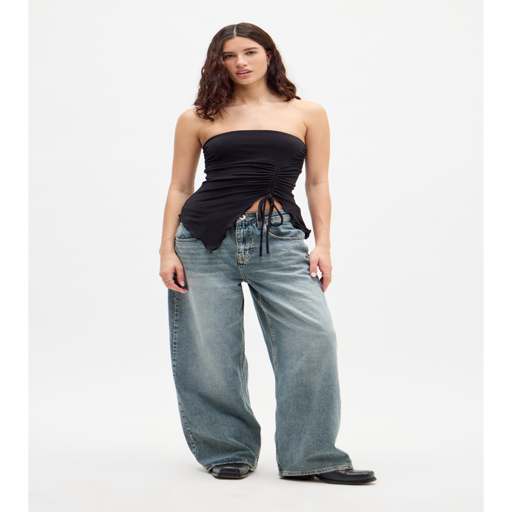

In [286]:
images[0].resize((512,512))

In [287]:
prompt_tensor=tokenize_query(model.model.tokenizer , "Is this a lifestyle image or a plain background image?" ,model.model.config.tokenizer.templates['query'] ,"").to('cuda')



In [288]:
prompt_tensor

tensor([[    1, 15381,     2,  4319,   465,   264, 10938,  1985, 41674,  6362,
          2695,  1985,    51,     3,     3]], device='cuda:0')

In [289]:
pos=encode_and_load_image(model.model , images[0])

In [290]:
attn_mask=get_attention_mask(model.model,pos)

In [291]:
def prefill_and_get_logits(
    model,
    prompt_tokens: torch.Tensor,
    pos: int,
    text_encoder,
    lm_head,
    temperature: float = 1.0,
    top_p: float = 1.0,
    spatial_refs: list = None,
    attn_mask: torch.Tensor = None,
    lora: dict = None,
    
):
    
    
    with torch.inference_mode():
        # Get text embeddings for prompt tokens
        prompt_emb = text_encoder(prompt_tokens, model.text)
        
        # Handle spatial references if provided
        if spatial_refs:
            encoded_refs = model.encode_spatial_refs(spatial_refs, model.region)
            prompt_emb[prompt_tokens == model.config.tokenizer.coord_id] = encoded_refs["coords"]
            if encoded_refs["sizes"] is not None:
                prompt_emb[prompt_tokens == model.config.tokenizer.size_id] = encoded_refs["sizes"]
        
        # Mark for dynamic compilation
        torch._dynamo.mark_dynamic(prompt_emb, 1)
        
        # Use provided attention mask or model's default
        if attn_mask is None:
            attn_mask = model.attn_mask
            
        # Create mask for this prompt sequence
        mask = attn_mask[:, :, pos : pos + prompt_emb.size(1), :]
        
        # Create position IDs for the prompt sequence
        pos_ids = torch.arange(pos, pos + prompt_emb.size(1), dtype=torch.long).to(model.device)
        
        # Run prefill to get hidden states
        hidden_BC = model._prefill(prompt_emb, mask, pos_ids, lora)
        
        # Get logits from language model head
        logits_BV = lm_head(hidden_BC, model.text)
        
        # Update position
        new_pos = pos + prompt_emb.size(1)
    
    return logits_BV, hidden_BC, new_pos

In [292]:
logits, hidden_states, new_pos = prefill_and_get_logits(
    model=model.model,
    prompt_tokens=prompt_tensor,
    text_encoder=text_encoder,
    lm_head=lm_head,
    pos=pos,
    attn_mask=attn_mask,
    
)

In [293]:
import importlib

def get_text_encoder_from_model(model):
    """Get text_encoder from the same module as the model"""
    model_module = importlib.import_module(model.__class__.__module__)
    return getattr(model_module, 'text_encoder')

def get_llm_head_from_model(model):
    """Get llm_head from the same module as the model"""
    model_module = importlib.import_module(model.__class__.__module__)
    return getattr(model_module, 'lm_head')


# Usage:
text_encoder = get_text_encoder_from_model(model)
lm_head = get_llm_head_from_model(model)


In [294]:
def analyze_token_probabilities(logits, tokenizer, top_k=10, temperature=1.0, top_p=None, apply_top_p_fn=None):
    """
    Convert logits to probabilities and analyze token probabilities with optional top-p filtering.
    
    Args:
        logits: Raw logits tensor (batch_size, vocab_size)
        tokenizer: Tokenizer to decode token IDs
        top_k: Number of top tokens to show
        temperature: Temperature for probability calculation
        top_p: Top-p threshold for nucleus sampling (None to disable)
        apply_top_p_fn: The _apply_top_p function from the model
        
    Returns:
        dict: Analysis results with probabilities and token info
    """
    
    # Apply temperature scaling
    scaled_logits = logits / temperature
    
    # Convert to probabilities
    probs = torch.softmax(scaled_logits, dim=-1)
    
    # Apply top-p filtering if specified
    filtered_probs = probs
    if top_p is not None and apply_top_p_fn is not None:
        filtered_probs = apply_top_p_fn(probs, top_p)
        
    # Count how many tokens survived top-p filtering
    active_tokens = (filtered_probs > 0).sum().item() if top_p is not None else probs.shape[-1]
    
    # Get top-k tokens from filtered probabilities
    top_probs, top_indices = torch.topk(filtered_probs, min(top_k, active_tokens), dim=-1)
    
    # Convert to lists for easier handling
    top_probs = top_probs.squeeze().tolist()
    top_indices = top_indices.squeeze().tolist()
    
    # Handle single token case
    if not isinstance(top_probs, list):
        top_probs = [top_probs]
        top_indices = [top_indices]
    
    # Decode tokens
    top_tokens = []
    for token_id in top_indices:
        try:
            if hasattr(tokenizer, 'decode'):
                token_text = tokenizer.decode([token_id])
            elif hasattr(tokenizer, 'id_to_token'):
                token_text = tokenizer.id_to_token(token_id)
            else:
                token_text = f"<ID:{token_id}>"
            top_tokens.append(token_text)
        except:
            top_tokens.append(f"<ID:{token_id}>")
    
    # Create analysis results
    results = {
        'original_probs': probs.squeeze(),
        'filtered_probs': filtered_probs.squeeze(),
        'top_k_analysis': [
            {
                'rank': i + 1,
                'token_id': int(top_indices[i]),
                'token_text': top_tokens[i],
                'probability': float(top_probs[i]),
                'percentage': float(top_probs[i] * 100),
                'original_prob': float(probs.squeeze()[top_indices[i]].item()),
                'original_percentage': float(probs.squeeze()[top_indices[i]].item() * 100)
            }
            for i in range(len(top_tokens))
        ],
        'entropy_original': float(-torch.sum(probs * torch.log(probs + 1e-10)).item()),
        'entropy_filtered': float(-torch.sum(filtered_probs * torch.log(filtered_probs + 1e-10)).item()) if top_p else None,
        'max_prob_original': float(torch.max(probs).item()),
        'max_prob_filtered': float(torch.max(filtered_probs).item()),
        'vocab_size': logits.shape[-1],
        'active_tokens_after_top_p': active_tokens,
        'top_p_applied': top_p is not None,
        'top_p_value': top_p
    }
    
    return results

def print_token_analysis(results, title="Token Probability Analysis"):
    """Pretty print the token analysis results with top-p info"""
    
    print(f"\n{title}")
    print("=" * 60)
    print(f"Vocabulary size: {results['vocab_size']}")
    
    if results['top_p_applied']:
        print(f"Top-p threshold: {results['top_p_value']}")
        print(f"Active tokens after top-p: {results['active_tokens_after_top_p']} / {results['vocab_size']}")
        print(f"Entropy (original): {results['entropy_original']:.4f}")
        print(f"Entropy (filtered): {results['entropy_filtered']:.4f}")
        print(f"Max probability (original): {results['max_prob_original']:.4f}")
        print(f"Max probability (filtered): {results['max_prob_filtered']:.4f}")
    else:
        print(f"Entropy: {results['entropy_original']:.4f}")
        print(f"Max probability: {results['max_prob_original']:.4f}")
    
    print(f"\nTop {len(results['top_k_analysis'])} most likely tokens:")
    print("-" * 60)
    
    if results['top_p_applied']:
        print("Rank | Token                | Filtered% | Original% | Token ID")
        print("-" * 60)
        for item in results['top_k_analysis']:
            token_display = repr(item['token_text']).replace("'", "")
            print(f"{item['rank']:4d} | {token_display:20s} | {item['percentage']:7.2f}% | {item['original_percentage']:7.2f}% | {item['token_id']}")
    else:
        print("Rank | Token                | Probability | Token ID")
        print("-" * 60)
        for item in results['top_k_analysis']:
            token_display = repr(item['token_text']).replace("'", "")
            print(f"{item['rank']:4d} | {token_display:20s} | {item['percentage']:9.2f}% | {item['token_id']}")

In [295]:
# With top-p filtering
results = analyze_token_probabilities(
    logits=logits,
    tokenizer=model.model.tokenizer,
    top_k=15,
    temperature=1.0,
    top_p=1,
    apply_top_p_fn=model.model._apply_top_p  # Pass the model's top-p function
)

print_token_analysis(results)


Token Probability Analysis
Vocabulary size: 51200
Top-p threshold: 1
Active tokens after top-p: 51200 / 51200
Entropy (original): 1.5312
Entropy (filtered): 1.5312
Max probability (original): 0.5742
Max probability (filtered): 0.5742

Top 15 most likely tokens:
------------------------------------------------------------
Rank | Token                | Filtered% | Original% | Token ID
------------------------------------------------------------
   1 | This is a            |   57.42% |   57.42% | 44185
   2 | The image            |   12.79% |   12.79% | 43016
   3 | L                    |   11.33% |   11.33% | 64
   4 | This                 |    5.35% |    5.35% | 826
   5 | Pl                   |    4.17% |    4.17% | 3357
   6 | A                    |    2.87% |    2.87% | 53
   7 | It is a              |    2.53% |    2.53% | 49016
   8 | The                  |    1.06% |    1.06% | 489
   9 | There is a           |    0.56% |    0.56% | 46010
  10 | It                   |    0.34% | 